In [1]:
# import things
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K

2025-01-13 16:14:10.513781: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-13 16:14:10.513871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-13 16:14:10.515475: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-13 16:14:10.524703: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# REQUIREMENT: Do not add code from Tasks 2 or 4
# REQUIREMENT: All dataset prep (crop/pad/patch/directory structure) must be finalize before attempting this task.
# Set seed for reproducibility
SEED = 24
BATCH_SIZE = 32
PATCH_SIZE = 256
PATCH_DIR = 'dataset_patched_final'

In [3]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives + K.epsilon())
        return precision

    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [4]:
# Define U-Net
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Contraction path
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.3)(c3)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = Dropout(0.3)(c4)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)

    # Expansive path
    u5 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(u5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1])
    return model

In [5]:
# Build U-Net
# REQUIREMENT: Model summary must be visible
model = simple_unet_model(PATCH_SIZE, PATCH_SIZE, 1)
model.summary()

2025-01-13 16:14:24.149129: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-01-13 16:14:24.151720: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16604 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         320       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 32)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['dropout[0][0]']             
                                                                                              

In [6]:
# Setup a generator for training
data_gen_args = dict(
    rotation_range=20,
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.05,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0
)

image_data_gen = ImageDataGenerator(**data_gen_args)
mask_data_gen = ImageDataGenerator(**data_gen_args)

train_image_generator = image_data_gen.flow_from_directory(
    os.path.join(PATCH_DIR, 'train_images'),
    target_size=(PATCH_SIZE, PATCH_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    color_mode='grayscale',
    seed=SEED
)

train_mask_generator = mask_data_gen.flow_from_directory(
    os.path.join(PATCH_DIR, 'train_masks'),
    target_size=(PATCH_SIZE, PATCH_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    color_mode='grayscale',
    seed=SEED
)

# Combine generators
def combine_generators(image_gen, mask_gen):
    for img, mask in zip(image_gen, mask_gen):
        yield img, mask

train_generator = combine_generators(train_image_generator, train_mask_generator)

Found 36663 images belonging to 1 classes.
Found 36663 images belonging to 1 classes.


In [7]:
# Setup a generator for validation
val_image_data_gen = ImageDataGenerator(rescale=1./255)
val_mask_data_gen = ImageDataGenerator(preprocessing_function=lambda x: np.where(x > 0, 1, 0).astype(x.dtype))

val_image_generator = val_image_data_gen.flow_from_directory(
    os.path.join(PATCH_DIR, 'val_images'),
    target_size=(PATCH_SIZE, PATCH_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    color_mode='grayscale',
    seed=SEED
)

val_mask_generator = val_mask_data_gen.flow_from_directory(
    os.path.join(PATCH_DIR, 'val_masks'),
    target_size=(PATCH_SIZE, PATCH_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    color_mode='grayscale',
    seed=SEED
)

val_generator = combine_generators(val_image_generator, val_mask_generator)

Found 5445 images belonging to 1 classes.
Found 5445 images belonging to 1 classes.


In [8]:
# EarlyStopping()
cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min', verbose=1)

In [9]:
# This is where the magic happens
# REQUIREMENT: The epoch logs must be visible showing validation loss and validation f1.
history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(train_image_generator),
    validation_steps=len(val_image_generator),
    epochs=30,
    callbacks=[
        ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1),
        cb
    ]
)

Epoch 1/30


2025-01-13 16:16:13.141129: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-01-13 16:16:13.932329: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2025-01-13 16:16:19.329289: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f020cf293e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-13 16:16:19.329511: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-01-13 16:16:19.336796: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736784979.562446  120668 device_compiler.h:186] Compiled cluster using XLA!  This lin

1146/1146 [==============================] - ETA: 0s - loss: 0.0227 - accuracy: 0.9946 - f1: 0.1348
Epoch 1: val_loss improved from inf to 0.01011, saving model to best_model.h5
1146/1146 [==============================] - 473s 384ms/step - loss: 0.0227 - accuracy: 0.9946 - f1: 0.1348 - val_loss: 0.0101 - val_accuracy: 0.9972 - val_f1: 0.4117
Epoch 2/30


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1146/1146 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9963 - f1: 0.6161
Epoch 2: val_loss improved from 0.01011 to 0.00556, saving model to best_model.h5
1146/1146 [==============================] - 406s 354ms/step - loss: 0.0073 - accuracy: 0.9963 - f1: 0.6161 - val_loss: 0.0056 - val_accuracy: 0.9982 - val_f1: 0.7156
Epoch 3/30
1146/1146 [==============================] - ETA: 0s - loss: 0.0063 - accuracy: 0.9965 - f1: 0.6472
Epoch 3: val_loss improved from 0.00556 to 0.00489, saving model to best_model.h5
1146/1146 [==============================] - 401s 350ms/step - loss: 0.0063 - accuracy: 0.9965 - f1: 0.6472 - val_loss: 0.0049 - val_accuracy: 0.9983 - val_f1: 0.7106
Epoch 4/30
1146/1146 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.9966 - f1: 0.6585
Epoch 4: val_loss did not improve from 0.00489
1146/1146 [==============================] - 400s 350ms/step - loss: 0.0060 - accuracy: 0.9966 - f1: 0.6585 - val_loss: 0.0052 - val_

In [10]:
# REQUIREMENT: Save your model, it is a deliverable
# REQUIREMENT: naming convention 'studentname_studentnumber_unet_model_patchsizepx.h5'
example_file_name = f'artjom_234535_unet_model_{PATCH_SIZE}px.h5'
print(example_file_name)
model.save(example_file_name)

artjom_234535_unet_model_256px.h5


In [11]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
best_val_loss = min(history.history['val_loss'])
best_val_f1 = max(history.history['val_f1'])
print(f"Best validation loss: {best_val_loss}")
print(f"Best validation f1: {best_val_f1}")

Best validation loss: 0.0031115426681935787
Best validation f1: 0.8237957954406738


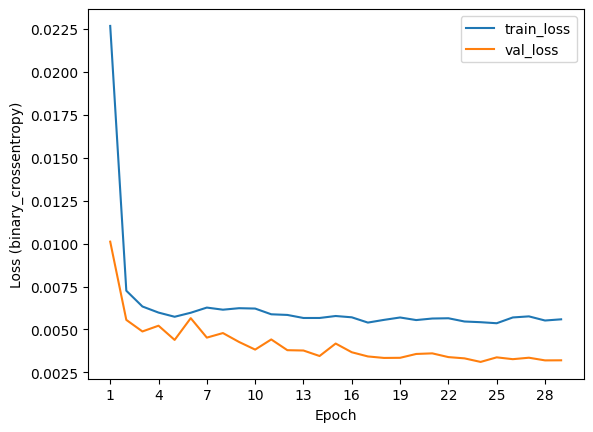

In [12]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = np.arange(1, len(loss) + 1)

plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (binary_crossentropy)')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))

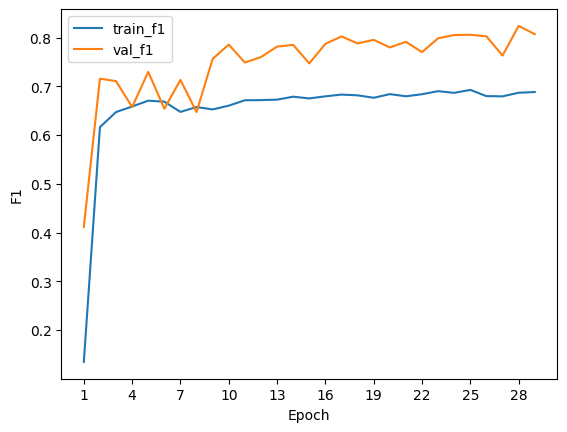

In [13]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
train_f1 = history.history['f1']
val_f1 = history.history['val_f1']

epochs = np.arange(1, len(train_f1) + 1)

plt.plot(epochs, train_f1, label='train_f1')
plt.plot(epochs, val_f1, label='val_f1')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))